We have plotted the mean, variance, skewness and kurtosis in code 1. and have convinced ourselves that its right. Now i will do NN training for mean in this code


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

import os
import argparse
import time

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=25)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [2]:
matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new.mat")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
# xExp = xExp.astype(double)

maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)

tExpTrunc = xExpTruncNormal[:,-1]

from scipy.interpolate import interp1d
# data Linear interpolation
dataLIFunc = interp1d(tExpTrunc, xExpTruncNormal, kind = "linear", axis=0)
tTrain = np.linspace(np.min(tExpTrunc), np.max(tExpTrunc), args.data_size)
xTrain = dataLIFunc(tTrain) 

Finding the derivative at any required point

In [3]:
dmeanBydtTemp = xTrain[1:,0]-xTrain[0:-1,0]
dvarBydtTemp = xTrain[1:,1]-xTrain[0:-1,1]
dskwBydtTemp = xTrain[1:,2]-xTrain[0:-1,2]
dkurtBydtTemp = xTrain[1:,3]-xTrain[0:-1,3]
timeStep= tTrain[1]-tTrain[0]

dmeanBydtTemp = dmeanBydtTemp/timeStep
dvarBydtTemp = dvarBydtTemp/timeStep
dskwBydtTemp = dskwBydtTemp/timeStep
dkurtBydtTemp = dkurtBydtTemp/timeStep

dmeanBydt = np.append(dmeanBydtTemp,dmeanBydtTemp[-1])
dvarBydt = np.append(dvarBydtTemp,dvarBydtTemp[-1])
dskwBydt = np.append(dskwBydtTemp,dskwBydtTemp[-1])
dkurtBydt = np.append(dkurtBydtTemp,dkurtBydtTemp[-1])

dm_dt_fun = interp1d(tTrain, dmeanBydt, axis=0, fill_value='extrapolate')
dv_dt_fun = interp1d(tTrain, dvarBydt, axis=0, fill_value='extrapolate')
ds_dt_fun = interp1d(tTrain, dskwBydt, axis=0, fill_value='extrapolate')
dk_dt_fun = interp1d(tTrain, dkurtBydt, axis=0, fill_value='extrapolate')

In [4]:
## Setting up the true system
true_y0 = torch.from_numpy(xTrain[0,:]).to(device).to(dtype=torch.double)
t = torch.from_numpy(tTrain).to(dtype=torch.double)
true_y = torch.from_numpy(xTrain).unsqueeze(1).to(dtype=torch.double)

In [5]:
## Get mini-batch data from the training dataset 
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=1)  # (T, M, D)
    batch_y=batch_y.permute(2,0,1,3)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [6]:
# Construct a neural network to approximate the dynamics of an ODE
class ODEFuncSkewness(nn.Module):

    def __init__(self):
        super(ODEFuncSkewness, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcSkewness = ODEFuncSkewness().to(device)

funcSkwLoaded = torch.load('skewnessFromNN.pth')

def combined_system(tVar, y):
    
    dt_dt = 1.0
    dt_dt = torch.tensor([dt_dt])

    dm_dt = dm_dt_fun(tVar.item()).item()
    dm_dt = torch.tensor([dm_dt]).to(dtype=torch.double)
    
    dv_dt = dv_dt_fun(tVar.item()).item()
    dv_dt = torch.tensor([dv_dt]).to(dtype=torch.double)
        
    ds_dt = funcSkwLoaded(tVar,y)
    
    dk_dt = dk_dt_fun(tVar.item()).item()
    dk_dt = torch.tensor([dk_dt]).to(dtype=torch.double)
    
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

In [7]:
ii = 0
def train_my_NN(learning_rate, count1, count2):
    # Setting up the optimizer with all parameters
    optimizer = optim.RMSprop(funcSkwLoaded.parameters(), lr=learning_rate)
    
    for itr in range(count1, count2):
    #for itr in range(1, 20):
            ## Using mini-batch data to update the neural network coefficients
            optimizer.zero_grad()
            batch_y0, batch_t, batch_y = get_batch()
            solutions = []
            temp1 = 0
            for ic in batch_y0:
                sol = odeint(combined_system, ic[0], batch_t[temp1])
                solutions.append(sol)
                temp1 = temp1+1
            pred_toCalcLoss= torch.stack(solutions)[:,:,2].unsqueeze(0)
            actual_toCalcLoss = batch_y[:,:,:,2]
            #pred_y = pred_y.permute(2, 1, 0, 3)
            loss = torch.mean(torch.abs(pred_toCalcLoss - actual_toCalcLoss))
            loss.backward()
            optimizer.step()
    
            if itr % args.test_freq == 0 or itr == 1:
                with torch.no_grad():
                    pred_y = odeint(combined_system, true_y0, t)
                    pred_toDisplay = pred_y[:,2].unsqueeze(1)
                    actual_toDisplay = true_y[:,:,2]
                    loss = torch.mean(torch.abs(pred_toDisplay - actual_toDisplay))
                    print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                    
count1 = 1
count2 = 500
lr = 0.005
train_my_NN(lr, count1, count2)

count1 = 500
count2 = 1000
lr = 0.0001
train_my_NN(lr, count1, count2)

count1 = 1000
count2 = 1500
lr = 0.0001
args.batch_size=50
train_my_NN(lr, count1, count2)

count1 = 1500
count2 = 2000
lr = 0.0001
args.batch_size=75
train_my_NN(lr, count1, count2)

Iter 0001 | Total Loss 1.058539
Iter 0020 | Total Loss 0.259452
Iter 0040 | Total Loss 0.277621
Iter 0060 | Total Loss 0.213325
Iter 0080 | Total Loss 0.115902
Iter 0100 | Total Loss 0.211549
Iter 0120 | Total Loss 0.201723
Iter 0140 | Total Loss 0.116697
Iter 0160 | Total Loss 0.114555
Iter 0180 | Total Loss 0.081382
Iter 0200 | Total Loss 0.113846
Iter 0220 | Total Loss 0.147822
Iter 0240 | Total Loss 0.165360
Iter 0260 | Total Loss 0.155496
Iter 0280 | Total Loss 0.144370
Iter 0300 | Total Loss 0.147623
Iter 0320 | Total Loss 0.059804
Iter 0340 | Total Loss 0.088681
Iter 0360 | Total Loss 0.226884
Iter 0380 | Total Loss 0.127510
Iter 0400 | Total Loss 0.023401
Iter 0420 | Total Loss 0.138504
Iter 0440 | Total Loss 0.122457
Iter 0460 | Total Loss 0.192805
Iter 0480 | Total Loss 0.031868
Iter 0500 | Total Loss 0.043840
Iter 0520 | Total Loss 0.035288
Iter 0540 | Total Loss 0.033302
Iter 0560 | Total Loss 0.031320
Iter 0580 | Total Loss 0.029760
Iter 0600 | Total Loss 0.028469
Iter 062

KeyboardInterrupt: 

In [8]:
count1 = 800
count2 = 1000
lr = 0.0001
train_my_NN(lr, count1, count2)

Iter 0800 | Total Loss 0.059810
Iter 0820 | Total Loss 0.025848
Iter 0840 | Total Loss 0.021566
Iter 0860 | Total Loss 0.022599
Iter 0880 | Total Loss 0.023749
Iter 0900 | Total Loss 0.026203
Iter 0920 | Total Loss 0.027683
Iter 0940 | Total Loss 0.024184
Iter 0960 | Total Loss 0.020299
Iter 0980 | Total Loss 0.022981


In [9]:
count1 = 1000
count2 = 1500
lr = 0.00001
args.batch_size=25
train_my_NN(lr, count1, count2)

Iter 1000 | Total Loss 0.023974
Iter 1020 | Total Loss 0.023786
Iter 1040 | Total Loss 0.022598
Iter 1060 | Total Loss 0.022922
Iter 1080 | Total Loss 0.022253
Iter 1100 | Total Loss 0.022489
Iter 1120 | Total Loss 0.022588
Iter 1140 | Total Loss 0.022854
Iter 1160 | Total Loss 0.022762


KeyboardInterrupt: 

In [10]:
count1 = 1180
count2 = 1500
lr = 0.00001
args.batch_size=25
train_my_NN(lr, count1, count2)

Iter 1180 | Total Loss 0.023685
Iter 1200 | Total Loss 0.024680
Iter 1220 | Total Loss 0.023441
Iter 1240 | Total Loss 0.023799
Iter 1260 | Total Loss 0.021820
Iter 1280 | Total Loss 0.021846
Iter 1300 | Total Loss 0.021264
Iter 1320 | Total Loss 0.021391
Iter 1340 | Total Loss 0.021290
Iter 1360 | Total Loss 0.022117


KeyboardInterrupt: 

In [14]:
count1 = 1380
count2 = 1700
lr = 0.00005
args.batch_size=75
train_my_NN(lr, count1, count2)

Iter 1380 | Total Loss 0.029181
Iter 1400 | Total Loss 0.020543
Iter 1420 | Total Loss 0.022165
Iter 1440 | Total Loss 0.023812
Iter 1460 | Total Loss 0.022408


KeyboardInterrupt: 

NameError: name 'temp_x_t_m_p2' is not defined

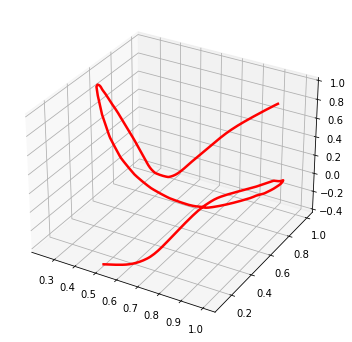

In [15]:
# Assuming ODEFunc is the name of your neural network class
modelMean = funcSkwLoaded
#modelVar = funcVariance
# modelSkw = funcSkewness
# modelKurt = funcKurtosis


modelMean.eval()
# modelVar.eval()
# modelSkw.eval()
# modelKurt.eval()


# Initial state
y0 = true_y0
#y0= torch.tensor([ 0,  0.5, 0, 0])

# Time point for prediction
t_value = t
with torch.no_grad():
    predicted_states = odeint(combined_system,y0 , t).to(device)
    
predicted_states=predicted_states.numpy()

plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

#ax.plot(x_train[:, 1], x_train[:, 2], x_train[:, 3], "k*", label="$given$")

ax.plot(predicted_states[:, 0], predicted_states[:, 1], predicted_states[:, 2], "r", label="$Neural-ODE-model$", linewidth=2.5,alpha =1)
ax.plot(temp_x_t_m_p2[:, 0], temp_x_t_m_p2[:, 1], temp_x_t_m_p2[:, 2], "b", label="True value", linewidth=2.5,alpha =0.6)
ax.set(xlabel="$Var$", ylabel="$Skw$", zlabel="$Kur$")
ax.legend()
fig.show()

#z_true = true_y[:,0,2].numpy()

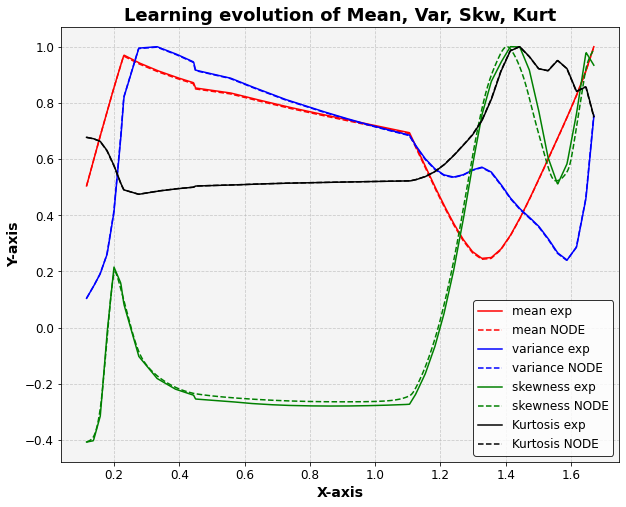

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tTrain,xTrain[:,0], 'r',label='mean exp')
plt.plot(tTrain,predicted_states[:,0], 'r--',label='mean NODE')

plt.plot(tTrain,xTrain[:,1], 'b',label='variance exp')
plt.plot(tTrain,predicted_states[:,1], 'b--',label='variance NODE')

plt.plot(tTrain,xTrain[:,2], 'g',label='skewness exp')
plt.plot(tTrain,predicted_states[:,2], 'g--',label='skewness NODE')

plt.plot(tTrain,xTrain[:,3], 'k',label='Kurtosis exp')
plt.plot(tTrain,predicted_states[:,3], 'k--',label='Kurtosis NODE')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Learning evolution of Mean, Var, Skw, Kurt", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

plt.savefig('plot5_Skw_all_parts.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [17]:
torch.save(funcSkwLoaded, 'skwLI.pth')